In [ ]:
import math
import networkx as nx
import matplotlib.pyplot as plt


# Load and Clean Up Traffic Light Data

In [175]:
import json
with open('Traffic Lights.json', 'r') as f:
    data = json.load(f)
    
# Don't include any ramp meters
lights = [light for light in data['elements'] if light['tags'].get('traffic_signals') != 'ramp_meter']
data['elements'] = lights


For each light, query for the street names of the intersection it lays on. Skips any lights that already have the name of the intersection. Takes several hours on a raw dataset because of a 1 request/second rate limit for the free tier. Dataset is fully populated so running it won't actually query any new data.

In [177]:
import requests
import time

def get_streets(lat, lon):
    api_key = '6625571d10da4926864985dug5dbcca'  

    # Get surrounding points
    delta = 0.00015
    points = [(lat, lon),
              (lat+delta, lon),
              (lat-delta, lon),
              (lat, lon+delta),
              (lat, lon-delta)]
    
    streets = []
    for point in points:
        # Send HTTP Request
        url = f"https://geocode.maps.co/reverse?lat={point[0]}&lon={point[1]}&api_key={api_key}"
        response = requests.get(url)
        time.sleep(1) # Free rate limit of 1 request per second

        # Extract road information
        if response.status_code == 200:
            data = response.json()
            street = data['address'].get('road')
            if street:
                streets.append(street)
        else:
            print(f"Error: {response.status_code}")
    
    # Return the intersection the light lies on
    return list(set(streets))

def query_traffic_light(data, index):
    # Get latitude and longitude
    traffic_light = data['elements'][index]
    lat, lon = traffic_light['lat'], traffic_light['lon']
    
    # Don't waste time if there's already an intersection defined
    if traffic_light.get('intersection'):
        print(f'Light {i}: ({lat}, {lon}) has an intersection')
        return
    
    # Get street names
    print(f'Light {i}: Querying ({lat}, {lon})')
    streets = get_streets(lat, lon)
    traffic_light['intersection'] = streets

    # Write to JSON file
    with open("Traffic Lights.json", "w") as outfile:
        json.dump(data, outfile, indent=4)

# Get intersection for each light
total_lights = len(data['elements'])
for i in range(total_lights):
    query_traffic_light(data, i)

In [178]:
# Explore the data, find all lights with a certain amount of intersections
filtered_lights = [light for light in lights if len(light['intersection'])>3]

for light in filtered_lights:
    print(light['lat'], ",", light['lon'], ':', light['intersection'])

41.880924 , -87.6172438 : ['Lakefront Trail', 'South DuSable Lake Shore Drive', 'East Monroe Drive', 'South Jean Baptiste Point DuSable Lake Shore Drive']
41.9008202 , -87.6241384 : ['East Lake Shore Drive', 'East Oak Street', 'North Lake Shore Drive', 'North Michigan Avenue']
41.8821148 , -87.6244855 : ['South Michigan Avenue', 'Grant Park North Garage (Entrance)', 'East Madison Street', 'North Michigan Avenue']
41.8820463 , -87.6277987 : ['East Madison Street', 'West Madison Street', 'North State Street', 'South State Street']
41.8869061 , -87.6354397 : ['West Lower Wacker Drive', 'North Orleans Street', 'West Upper Wacker Drive', 'North Franklin Street']
41.8867685 , -87.6354392 : ['West Upper Wacker Drive', 'West Lower Wacker Service Drive', 'North Franklin Street', 'West Lower Wacker Drive', 'North Orleans Street']
41.9039455 , -87.6286906 : ['East Division Street', 'West Division Street', 'North State Street', 'North State Parkway']
41.8964922 , -87.6415591 : ['North Cambridge Av

# Traffic Light Network Graph

### Create Traffic Light Network Graph 

Populate a graph with all the nodes

In [179]:
# Get data
with open('Traffic Lights.json', 'r') as f:
    data = json.load(f)
lights = data['elements']


# Initial population of the graph
G = nx.Graph()
graph = {}
for light in lights:
    G.add_node(light['id'], 
               pos=(light['lon'], light['lat']),
               lat=light['lat'], 
               lon=light['lon'],
               intersections=light['intersection'])
    
    graph[light['id']] = {
        'lat': light['lat'],
        'lon': light['lon'],
        'intersection': light['intersection'],
        'connections': []
    }

Connect all lights that share a street. Takes around 10 seconds

In [180]:
# Connect lights that share a street
def dist_metric(light1, light2):
    max_dist =  0.22074580639018443
    dist = math.dist([light1['lat'], light1['lon']], [light2['lat'], light2['lon']])
    
    return dist/max_dist

for curr_light in lights:
    curr_id = curr_light['id']

    # Go through each light
    for light in lights:
        # Don't compare to itself
        if light['id'] == curr_id:
            continue

        # Check if the lights share a street
        if not set(light['intersection']).isdisjoint(curr_light['intersection']):
            G.add_edge(curr_id, light['id'], weight=dist_metric(curr_light, light))

Assign each node a weight

In [181]:
def node_weight(G, node_id):
    # Initialize a list to store weights of edges connected to the node
    weights = []

    # Iterate over all edges connected to the node
    for neighbor in G.neighbors(node_id):
        # Access the weight of the edge between node_id and neighbor
        weight = G.edges[node_id, neighbor]['weight']
        weights.append(weight)
        
    # Calculate the average of weights
    if len(weights) == 0:
        return 1

    average_weight = sum(weights) / len(weights)
    return average_weight

for node_id in G.nodes():
    # Calculate the weight for the current node
    weight = node_weight(G, node_id)
    # Update the 'weight' attribute of the node
    G.nodes[node_id]['weight'] = weight

Edges ordered by weight (for exploration)

In [182]:
# Order edges based on weight (for exploration)
x = sorted(G.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)
x[0]

(33754414, 261170509, {'weight': 1.0})

### Display Graph

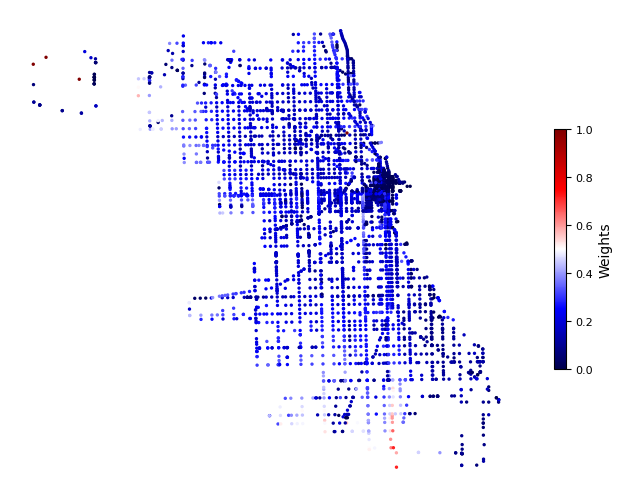

In [183]:
# Get edge and node weights
edges,e_weights = zip(*nx.get_edge_attributes(G,'weight').items())
nodes,n_weights = zip(*nx.get_node_attributes(G,'weight').items())
pos=nx.get_node_attributes(G,'pos')

# Draw and save graph
nx.draw(G, pos, 
        node_color=n_weights, node_size=2, cmap=plt.cm.seismic,
        edge_color=e_weights, edge_cmap=plt.cm.seismic)
colorbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.seismic), label='Weights', shrink=0.5)
colorbar.ax.yaxis.set_tick_params(labelsize=8)

plt.savefig("graph.png", dpi=1000)
plt.show()

# Graph-level Metrics

Diameter
Clustering Coeff.

### Display the Distinct Connected Components

# of distinct components: 7


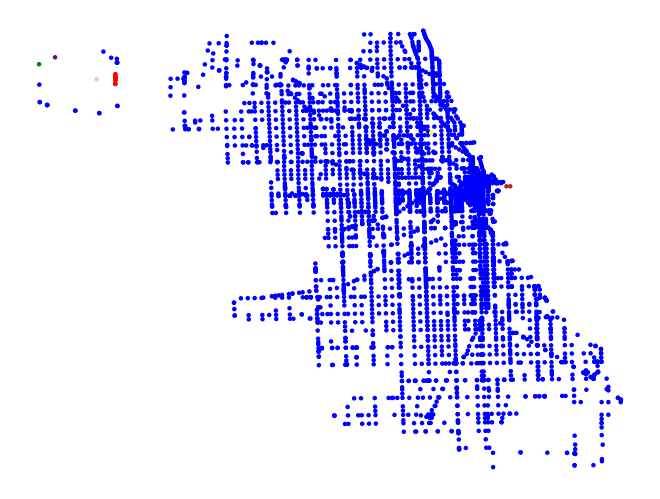

In [258]:
# Get separate connected components
components = list(nx.connected_components(G))
color_map = []
C = nx.Graph()

print("# of distinct components:", len(components))
colors = ['blue', 'red', 'green', 'yellow', 'pink', 'purple', 'brown']

for i in range(len(components)):
    for j in components[i]:
        pos = nx.get_node_attributes(G, 'pos')[j]
        C.add_node(j, pos=pos)
        color_map.append(colors[i])


pos=nx.get_node_attributes(C,'pos')
nx.draw(C, pos, node_color=color_map, node_size=5)


### Diameter of largest connected component

Calculate the weighted diameter of the graph. Takes about 41 minutes. (diameter = 3.0773893)

In [260]:
# Make a graph with the largest connected component
C1 = G.subgraph(components[0]) 

# Find the weighted diameter
diameter = nx.diameter(C1, weight='weight')
diameter

3.077389306932374

### Betweeness Centrality

Calculates the betweeness measure for each node. Takes about 16 minutes

In [263]:
betweeness = nx.betweenness_centrality(G, weight='weight')
betweeness

{26098097: 0.0,
 26098113: 0.0017627721416835372,
 26099529: 0.0003685176321416078,
 26099536: 0.0027371085131614346,
 26099544: 0.0001555907206300414,
 26220949: 0.0,
 26220951: 0.0,
 26220970: 0.001092292323643854,
 26794540: 0.0,
 26794541: 0.0018678463945765523,
 26794543: 0.0029026762361695387,
 26794544: 0.00057828726441961,
 26794545: 0.0016795462610867862,
 26794546: 0.0002976682861404282,
 26794549: 0.0006958643430775391,
 26794555: 4.98850118903136e-05,
 26794558: 0.0010887561709022621,
 26794572: 0.0005045332215235515,
 26794585: 0.0006522938896543537,
 26794593: 2.79103484247071e-05,
 26794602: 0.0022277762272028654,
 26794603: 0.002841425019038394,
 26794605: 0.0007129136509387854,
 26794614: 0.0035292067272780087,
 26808044: 0.000690938987473179,
 26808049: 3.094133648892869e-05,
 26808054: 0.0011284115980758277,
 26808055: 0.0001049479617236724,
 26808056: 0.002619657725672848,
 26808650: 0.00011606158462581821,
 26808653: 0.0029129058208862864,
 26817935: 0.000483063722

### Closeness Centrality

Calculates closeness centrality for each node. Takes about 15 minutes

In [264]:
closeness = nx.closeness_centrality(G, distance='weight')
closeness

{26098097: 1.9166269296647849,
 26098113: 1.9999745125063546,
 26099529: 1.8267116374657884,
 26099536: 1.854926516419014,
 26099544: 1.7094125675664547,
 26220949: 1.4323591831383224,
 26220951: 1.4724853285091115,
 26220970: 1.4437177639373928,
 26794540: 1.6173594526672503,
 26794541: 1.6302305101510555,
 26794543: 1.6557553480810079,
 26794544: 1.6405550235017807,
 26794545: 1.685743276728393,
 26794546: 1.6835428511084383,
 26794549: 1.6883005663442539,
 26794555: 1.6845929626276814,
 26794558: 1.697063776969529,
 26794572: 1.6263380062334798,
 26794585: 1.6521279081405993,
 26794593: 1.6208113344002635,
 26794602: 1.6282346132061758,
 26794603: 1.6211100228389699,
 26794605: 1.6261829095021136,
 26794614: 1.6078675968736482,
 26808044: 1.7176240801685052,
 26808049: 1.8582796076051862,
 26808054: 1.822814841540558,
 26808055: 1.808145935717311,
 26808056: 1.792071772754111,
 26808650: 1.733265460554168,
 26808653: 1.7522679644399384,
 26817935: 1.854827227616614,
 26817972: 1.947

# Node-level Metrics

Betweeness
Closeness
Node clustering coeff
Degree